In [2]:
import numpy as np
from scipy import optimize
import pandas as pd
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from scipy.special import gamma
from math import pi

Get Data

In [6]:
""" Data Importation """

#path = "C:/Users/Amaury/Documents/CentraleSupelec/3A/Projet/"
file = "Data issuers.xlsx"
market_cap = pd.read_excel(file, sheet_name="Mod Market Cap")
market_cap = market_cap.set_index("Dates").loc['2019-10-28':'2020-10-13']
debt = pd.read_excel(file, sheet_name="Gross Debt", nrows=1)

Merton Model

In [7]:
def BSM(ticker, market_cap, debt, T=1, frequency=252, rf=0, epsilon=10e-5):
    company_debt = debt[[ticker]].iloc[0, 0]
    company_market_cap = market_cap[[ticker]].iloc[:, 0]
    current_time = 0
    equity_value = 0
    sigma_A = 0
    sigma_A_former = 0
    asset_values = []

    def d1_m(x, sigma_A, current_time):
        return ((np.log(x / company_debt)) + (rf + 0.5 * sigma_A ** 2) * current_time) / (
                sigma_A * np.sqrt(current_time))

    def d2_m(x, sigma_A, current_time):
        return d1_m(x, sigma_A, current_time) - sigma_A * np.sqrt(current_time)

    # inverse the black scholes formula
    def merton_formula(x, rf, current_time):
        d1_term = x * norm.cdf(d1_m(x, sigma_A, current_time))
        d2_term = company_debt * np.exp(-rf * current_time) * norm.cdf(d2_m(x, sigma_A, current_time))
        return d1_term - d2_term - equity_value

    sigma_E = np.std(np.diff(np.log(company_market_cap), n=1)) * np.sqrt(frequency)
    sigma_A = sigma_E

    while np.abs(sigma_A - sigma_A_former) > epsilon:

        asset_values = []

        for dt in range(company_market_cap.shape[0]):
            current_time = T + (frequency - dt - 1) / frequency
            equity_value = company_market_cap[dt]
            # find zero of Merton function, ie asset_value at the current_time
            asset_values.append(optimize.newton(merton_formula, company_debt, args=(rf, current_time)))

        # update of sigma_A and sigma_A_former
        sigma_A_former = sigma_A
        sigma_A = np.std(np.diff(np.log(asset_values), n=1)) * np.sqrt(frequency)

    # compute distance to default and default probability
    distance_to_default = d2_m(asset_values[-1], sigma_A, current_time)
    default_probability = (1 - norm.cdf(distance_to_default)) * 100

    distance_to_default_real = -d2_m(asset_values[-1], sigma_A, current_time)
    default_probability_real = norm.cdf(distance_to_default) * 100 # notation approximation : non default probability
    #print(distance_to_default_real)
    #print(default_probability_real)

    return sigma_A, distance_to_default, default_probability

Merton Model with Fractional Brownian Motion

In [8]:

def update_values_regression_fixed_intercept(Var, delta_t, sigma_A, iteration, plot=False):
    var_tau = np.array(Var)

    # Transformation logarithmique
    log_delta_t = np.log(delta_t)
    log_var_tau = np.log(var_tau)

    fixed_intercept_log_sigma2 = np.log(var_tau[0]) # assuming delta = 1 otherwise H is here

    # Régression linéaire
    X = log_delta_t.reshape(-1, 1)
    y = log_var_tau - fixed_intercept_log_sigma2

    model = LinearRegression(fit_intercept=False)
    model.fit(X, y)
    #print('Regression score for H is ',model.score(X, y))

    # Coefficients de la régression
    slope = model.coef_[0]

    # Calcul de H
    H = slope / 2
    sigma_A_former = sigma_A
    sigma_A = np.sqrt(var_tau[0]) * ((int(252/delta_t[0]))**(H))

    if plot:
        plt.scatter(log_delta_t, y, label='Données')
        plt.plot(log_delta_t, model.predict(log_delta_t.reshape(-1, 1)), color='red', label='Régression linéaire')
        plt.xlabel('log(Delta t)')
        plt.ylabel('log(Var(tau(Delta t)))')
        plt.title(f"Régression de l'itération {iteration}")
        plt.legend()
        plt.show()

    return sigma_A, sigma_A_former, H

#d2_hurst is used to calculate the default probability
def d1_hurst(x, sigma_A, t, T ,H, rf, company_debt):
    return ((np.log(x / company_debt)) + rf * (T-t) + (0.5 * sigma_A ** 2) * (T ** (2 * H) - t ** (2 * H))) / (
            sigma_A * (T - t)**H)
def d2_hurst(x, sigma_A, t, T, H, rf, company_debt):
    return d1_hurst(x, sigma_A, t, T, H, rf, company_debt) - sigma_A * (T - t)**H

Adapted Merton Formula from Necula

In [9]:
#d1 and d2 from Necula
def d1(x, sigma_A, t, T, H, rf, company_debt):
    return ((np.log(x / company_debt)) + rf * (T - t) + 0.5 * sigma_A ** 2 * (T ** (2 * H) - t ** (2 * H)) / (
            sigma_A * np.sqrt(T ** (2 * H) - t ** (2 * H))))


def d2(x, sigma_A, t, T, H, rf, company_debt):
    return ((np.log(x / company_debt)) + rf * (T - t) - 0.5 * sigma_A ** 2 * (T ** (2 * H) - t ** (2 * H)) / (
            sigma_A * np.sqrt(T ** (2 * H) - t ** (2 * H))))


# inverse the black scholes formula with Necula's expresions for d1 and d2
def merton_formula(x, rf, t, T, H, company_debt, equity_value, sigma_A):
    d1_term = x * norm.cdf(d1(x, sigma_A, t, T, H, rf, company_debt))
    d2_term = company_debt * np.exp(-rf * (T - t)) * norm.cdf(d2(x, sigma_A, t, T, H, rf, company_debt))
    return d1_term - d2_term - equity_value


def BSM_H(ticker, market_cap, debt, T=1, delta=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], rf=0, epsilon=10e-3, H0=0.5):
    frequency = []
    for d in delta:
        frequency.append(252 // d)
    company_debt = debt[[ticker]].iloc[0, 0]
    company_market_cap = market_cap[[ticker]].iloc[:, 0]
    sigma_A_former = 0
    H = H0
    sigma_E = np.std(np.diff(np.log(company_market_cap), n=1)) * np.sqrt(frequency[0])
    sigma_A = sigma_E

    n_iter = 1
    while np.abs(sigma_A - sigma_A_former) > epsilon:
        #print("Iteration ", n_iter)
        asset_values = {}
        for f in frequency:
            fasset_values = []
            n = company_market_cap.shape[0]
            days = []
            for i in range(n):
                if i % (n // f) == 0:
                    days.append(i)
            for day in days:
                t = day / n
                equity_value = company_market_cap[day]
                # find zero of Merton function, ie asset_value at the current_time
                fasset_values.append(optimize.newton(merton_formula, company_debt,
                                                     args=(rf, t, 1 + T, H, company_debt, equity_value, sigma_A),
                                                     maxiter=100))
            asset_values[f] = fasset_values

        # update values
        Var = []
        for i, f in enumerate(frequency):
            Var.append(np.var(np.diff(np.log(asset_values[f]), n=1)) )# *f)

        Mean = []
        for i, f in enumerate(frequency):
            Mean.append(np.mean(np.diff(np.log(asset_values[f]), n=1)))# *f)

        n_iter += 1
        #print("update values")
        sigma_A, sigma_A_former, H = update_values_regression_fixed_intercept(Var, delta, sigma_A, n_iter, False)
        #print(f"sigma= {sigma_A}, H={H}")

    assert len(Mean) == len(delta)
    mu = [round((Mean[k] + ((sigma_A**2)/(2*t)) * ((t+delta[k])**(2*H+1) - t**(2*H+1) - delta[k]**(2*H+1)) / (2*H+1)) / delta[k], 3) for k in range(len(delta))]
    #print(mu)
    # compute distance to default and default probability
    t = 1
    distance_to_default = d2_hurst(asset_values[frequency[0]][-1], sigma_A, t, t + T, H, mu[-1], company_debt)
    default_probability = (1 - norm.cdf(distance_to_default)) * 100
    return distance_to_default, default_probability, H


Adapted Merton formula from Rostek

In [10]:

def ro_h(H):
    if H!=0.5:
        return( (np.sin(pi*(H-0.5))/(pi*(H-0.5)))*((gamma(1.5-H)**2)/(gamma(2-2*H))) )
    return( (gamma(1.5-H)**2)/(gamma(2-2*H)))


def d1_rostek(x, sigma_A, t, T, H, rf, company_debt, roH):
    return(
       ((np.log(x / company_debt)) + rf * (T-t) + 0.5* roH * ((sigma_A )** 2 )* ((T-t)**(2*H)))
       /(np.sqrt(roH)*sigma_A*((T-t)**H))
    )

def d2_rostek(x, sigma_A, t, T, H, rf, company_debt, roH):
    return(
        d1_rostek(x, sigma_A, t, T, H, rf, company_debt, roH) - np.sqrt(roH)*sigma_A*((T-t)**H)
    )


def merton_formula_rostek(x, rf, t, T, H, company_debt, equity_value, sigma_A, roH):
    d1_term=x * norm.cdf(d1_rostek(x, sigma_A, t, T, H, rf, company_debt, roH))
    d2_term=company_debt * np.exp(-rf * (T - t)) * norm.cdf(d2_rostek(x, sigma_A, t, T, H, rf, company_debt, roH))
    return (d1_term - d2_term - equity_value)


def BSM_H_rostek(ticker, market_cap, debt, T=1, delta=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], rf=0, epsilon=10e-3, H0=0.5):
    frequency = []
    for d in delta:
        frequency.append(252 // d)
    company_debt = debt[[ticker]].iloc[0, 0]
    company_market_cap = market_cap[[ticker]].iloc[:, 0]
    sigma_A_former = 0
    H = H0
    roH= ro_h(H)
    sigma_E = np.std(np.diff(np.log(company_market_cap), n=1)) * np.sqrt(frequency[0])
    sigma_A = sigma_E

    n_iter = 1
    while np.abs(sigma_A - sigma_A_former) > epsilon:
        #print("Iteration ", n_iter)
        asset_values = {}
        for f in frequency:
            fasset_values = []
            n = company_market_cap.shape[0]
            days = []
            for i in range(n):
                if i % (n // f) == 0:
                    days.append(i)
            for day in days:
                t = day / n
                equity_value = company_market_cap[day]
                # find zero of Merton function, ie asset_value at the current_time
                fasset_values.append(optimize.newton(merton_formula_rostek, company_debt,
                                                     args=(rf, t, 1 + T, H, company_debt, equity_value, sigma_A,roH),
                                                     maxiter=100))
            asset_values[f] = fasset_values

        # update values
        Var = []
        for i, f in enumerate(frequency):
            Var.append(np.var(np.diff(np.log(asset_values[f]), n=1)) )# *f)

        Mean = []
        for i, f in enumerate(frequency):
            Mean.append(np.mean(np.diff(np.log(asset_values[f]), n=1)))# *f)

        n_iter += 1
        #print("update values")
        sigma_A, sigma_A_former, H = update_values_regression_fixed_intercept(Var, delta, sigma_A, n_iter, plot=False)
        roH= ro_h(H)
        #print(f"sigma= {sigma_A}, H={H}")

    assert len(Mean) == len(delta)
    mu = [round((Mean[k] + ((sigma_A**2)/(2*t)) * ((t+delta[k])**(2*H+1) - t**(2*H+1) - delta[k]**(2*H+1)) / (2*H+1)) / delta[k], 3) for k in range(len(delta))]
    #print(mu)
    # compute distance to default and default probability
    t = 1
    distance_to_default = d2_hurst(asset_values[frequency[0]][-1], sigma_A, t, t + T, H, mu[-1], company_debt)
    default_probability = (1 - norm.cdf(distance_to_default)) * 100
    return distance_to_default, default_probability, H


CRH LN Equity Hurst : 0.5181018452646352


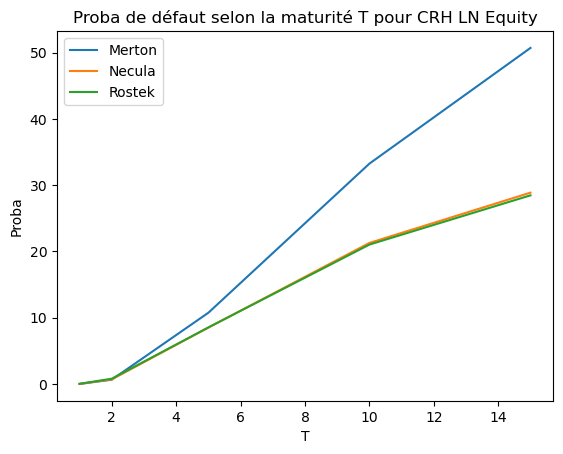

In [11]:

ticker = market_cap.columns[0]
maturity = [1, 2, 5, 10, 15]
proba_merton = np.zeros(len(maturity))
proba_necula = np.zeros(len(maturity))
proba_rostek = np.zeros(len(maturity))


for i, m in enumerate(maturity):
    proba_merton[i] = BSM(ticker, market_cap, debt, T=m)[2]
    proba_necula[i] = BSM_H(ticker, market_cap, debt, T=m)[1]
    proba_rostek[i] = BSM_H_rostek(ticker, market_cap, debt, T=m)[1]


print(f"{ticker} Hurst : { BSM_H(ticker, market_cap, debt, T=1)[2]}")

plt.figure()
plt.plot(maturity, proba_merton, label="Merton")
plt.plot(maturity, proba_necula, label="Necula")
plt.plot(maturity, proba_rostek, label="Rostek")
plt.legend()
plt.title(f"Proba de défaut selon la maturité T pour {ticker}")
plt.xlabel("T")
plt.ylabel("Proba")
plt.show()


FGR FP Equity Hurst : 0.5886778203650024


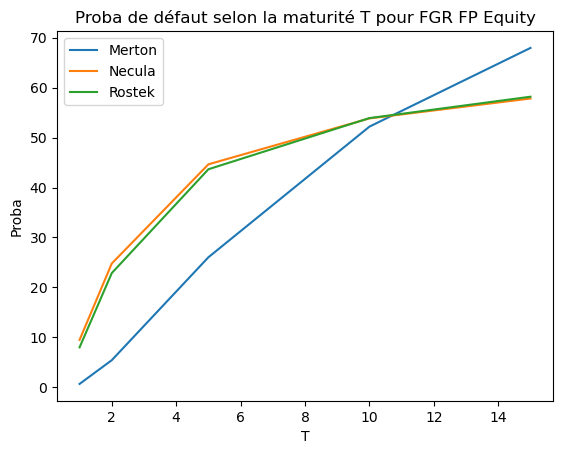

In [12]:

ticker = market_cap.columns[1]
maturity = [1, 2, 5, 10, 15]
proba_merton = np.zeros(len(maturity))
proba_necula = np.zeros(len(maturity))
proba_rostek = np.zeros(len(maturity))


for i, m in enumerate(maturity):
    proba_merton[i] = BSM(ticker, market_cap, debt, T=m)[2]
    proba_necula[i] = BSM_H(ticker, market_cap, debt, T=m)[1]
    proba_rostek[i] = BSM_H_rostek(ticker, market_cap, debt, T=m)[1]


print(f"{ticker} Hurst : { BSM_H(ticker, market_cap, debt, T=1)[2]}")

plt.figure()
plt.plot(maturity, proba_merton, label="Merton")
plt.plot(maturity, proba_necula, label="Necula")
plt.plot(maturity, proba_rostek, label="Rostek")
plt.legend()
plt.title(f"Proba de défaut selon la maturité T pour {ticker}")
plt.xlabel("T")
plt.ylabel("Proba")
plt.show()

FR FP Equity Hurst : 0.5925130485192549


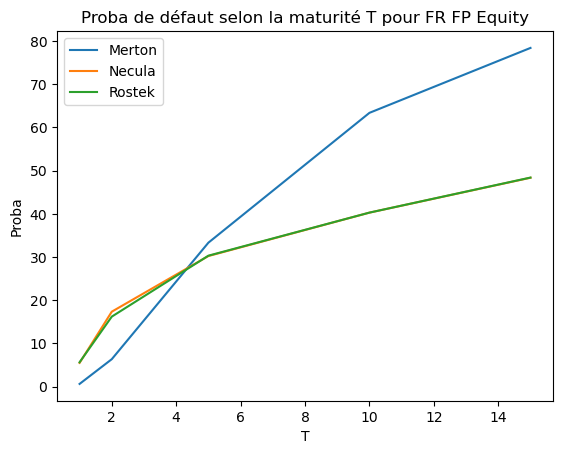

In [13]:
ticker = market_cap.columns[2]
maturity = [1, 2, 5, 10, 15]
proba_merton = np.zeros(len(maturity))
proba_necula = np.zeros(len(maturity))
proba_rostek = np.zeros(len(maturity))


for i, m in enumerate(maturity):
    proba_merton[i] = BSM(ticker, market_cap, debt, T=m)[2]
    proba_necula[i] = BSM_H(ticker, market_cap, debt, T=m)[1]
    proba_rostek[i] = BSM_H_rostek(ticker, market_cap, debt, T=m)[1]


print(f"{ticker} Hurst : { BSM_H(ticker, market_cap, debt, T=1)[2]}")

plt.figure()
plt.plot(maturity, proba_merton, label="Merton")
plt.plot(maturity, proba_necula, label="Necula")
plt.plot(maturity, proba_rostek, label="Rostek")
plt.legend()
plt.title(f"Proba de défaut selon la maturité T pour {ticker}")
plt.xlabel("T")
plt.ylabel("Proba")
plt.show()

VIE FP Equity Hurst : 0.5732280433571701


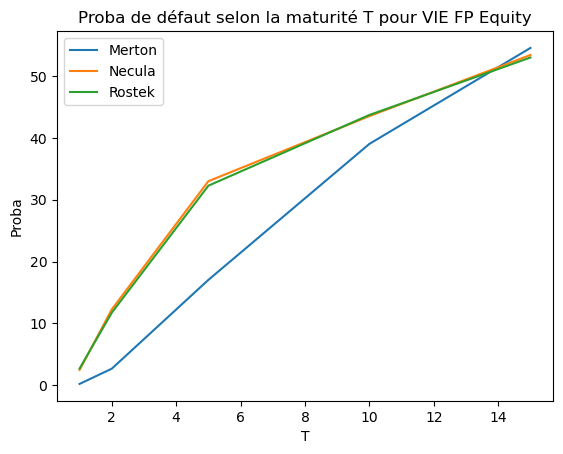

In [14]:
ticker = market_cap.columns[3]
maturity = [1, 2, 5, 10, 15]
proba_merton = np.zeros(len(maturity))
proba_necula = np.zeros(len(maturity))
proba_rostek = np.zeros(len(maturity))


for i, m in enumerate(maturity):
    proba_merton[i] = BSM(ticker, market_cap, debt, T=m)[2]
    proba_necula[i] = BSM_H(ticker, market_cap, debt, T=m)[1]
    proba_rostek[i] = BSM_H_rostek(ticker, market_cap, debt, T=m)[1]


print(f"{ticker} Hurst : { BSM_H(ticker, market_cap, debt, T=1)[2]}")

plt.figure()
plt.plot(maturity, proba_merton, label="Merton")
plt.plot(maturity, proba_necula, label="Necula")
plt.plot(maturity, proba_rostek, label="Rostek")
plt.legend()
plt.title(f"Proba de défaut selon la maturité T pour {ticker}")
plt.xlabel("T")
plt.ylabel("Proba")
plt.show()